<a href="https://colab.research.google.com/github/rudycav/Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [520]:
import numpy as np
import math
import requests
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import sem

In [521]:
symbol = 'ETH'

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' E7KN41UXPEIKWXIK'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = symbol, exchange = 'USD', start_date = '2015-05-01')
crypto_df.head()

,open,high,low,close,volume
Date,,,,,
2019-11-06,188.65,195.09,187.72,191.16,343219.92240
2019-11-07,191.16,192.27,184.59,186.68,309882.08206
2019-11-08,186.67,188.26,181.41,183.74,365029.75027
2019-11-09,183.71,185.79,182.63,184.89,192073.38044
2019-11-10,184.86,191.58,183.30,188.96,274940.53448


In [522]:
forecast_days = 12

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['high']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column.tail()

,open,high,low,close,volume,forecast
Date,,,,,,
2022-07-28,1635.74,1784.79,1593.27,1724.52,1.578145e+06,NaN
2022-07-29,1724.52,1765.99,1655.02,1721.68,1.205267e+06,NaN
2022-07-30,1721.68,1744.85,1673.01,1697.00,7.351325e+05,NaN
2022-07-31,1697.00,1754.69,1666.00,1678.12,6.963268e+05,NaN
2022-08-01,1678.12,1690.58,1672.63,1683.20,2.448297e+04,NaN


In [523]:
def smooth_data(data, alpha):

    return data.ewm(alpha=alpha).mean()

expo_smooth = smooth_data(prediction_column, 0.65)


In [524]:
def create_dataset(df):
  independent_dataset = np.array(prediction_column.high)
  independent_dataset = independent_dataset[:-forecast_days]

  dependent_dataset = prediction_column.forecast.values
  dependent_dataset = dependent_dataset[:-forecast_days]

  return independent_dataset, dependent_dataset

x_dataset, y_dataset = create_dataset(expo_smooth)

In [525]:
x_dataset.shape

(988,)

In [526]:
y_dataset.shape

(988,)

In [527]:
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)

In [528]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691, 1), (297, 1), (691,), (297,))

In [529]:
def regression_model(X_train, y_train, X_test, y_test):
  lin_reg_model = LinearRegression()
  lin_reg_model.fit(X_train, y_train)

  score_acc = lin_reg_model.score(X_test, y_test)
  score_acc = round(score_acc,2)
  score_acc

  return lin_reg_model, score_acc

linear_regression_model, accuracy_score = regression_model(X_train, y_train, X_test, y_test)

In [530]:
print(f'Model accuracy score: {accuracy_score}')

Model accuracy score: 0.94


In [531]:
def model_results(df):
  actual_price = np.array(crypto_df[['high']])
  model_predictions = linear_regression_model.predict(actual_price)

  model_predictions_df = pd.DataFrame(model_predictions, columns=['Model Results'])
  model_predictions_df.index.name = 'Date'
  model_predictions_df.index = crypto_df.index

  return model_predictions_df

model_predictions_df = (model_results(crypto_df))


In [532]:
model_predictions_df.head()

,Model Results
Date,
2019-11-06,271.164516
2019-11-07,268.454930
2019-11-08,264.601937
2019-11-09,262.228647
2019-11-10,267.791946


In [533]:
def create_prediction(df):
  actual_price = np.array(crypto_df[['high']])[-forecast_days:]
  forecast_prediction = linear_regression_model.predict(actual_price)

  return forecast_prediction

forecast_prediction = (create_prediction(crypto_df))


In [534]:
forecast_prediction

array([1626.81268886, 1669.15717708, 1617.71347616, 1682.88766804,
       1630.24290948, 1480.88898961, 1663.76683038, 1798.6215824 ,
       1780.55767547, 1760.24538863, 1769.70011439, 1708.10027006])

In [535]:
def get_future_dates(datetime):
  future_dates = []

  datetime = datetime

  for i in range(forecast_days): 
    datetime += timedelta(days=1)
    future_dates.append(datetime.strftime('%Y-%m-%d'))

  return future_dates

future_dates = get_future_dates(datetime.now())

In [536]:
def datetime_index(forecast_df, crypto_df):

  forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
  forecast_df['Date'] = future_dates
  forecast_df.set_index('Date', inplace=True)
  forecast_df.index = pd.to_datetime(forecast_df.index)
  crypto_df.index = pd.to_datetime(crypto_df.index)

  return forecast_df, crypto_df

forecast_df, crypto_df = datetime_index(future_dates, crypto_df)

In [537]:
print(forecast_df.head())

               forecast
Date                   
2022-08-02  1626.812689
2022-08-03  1669.157177
2022-08-04  1617.713476
2022-08-05  1682.887668
2022-08-06  1630.242909


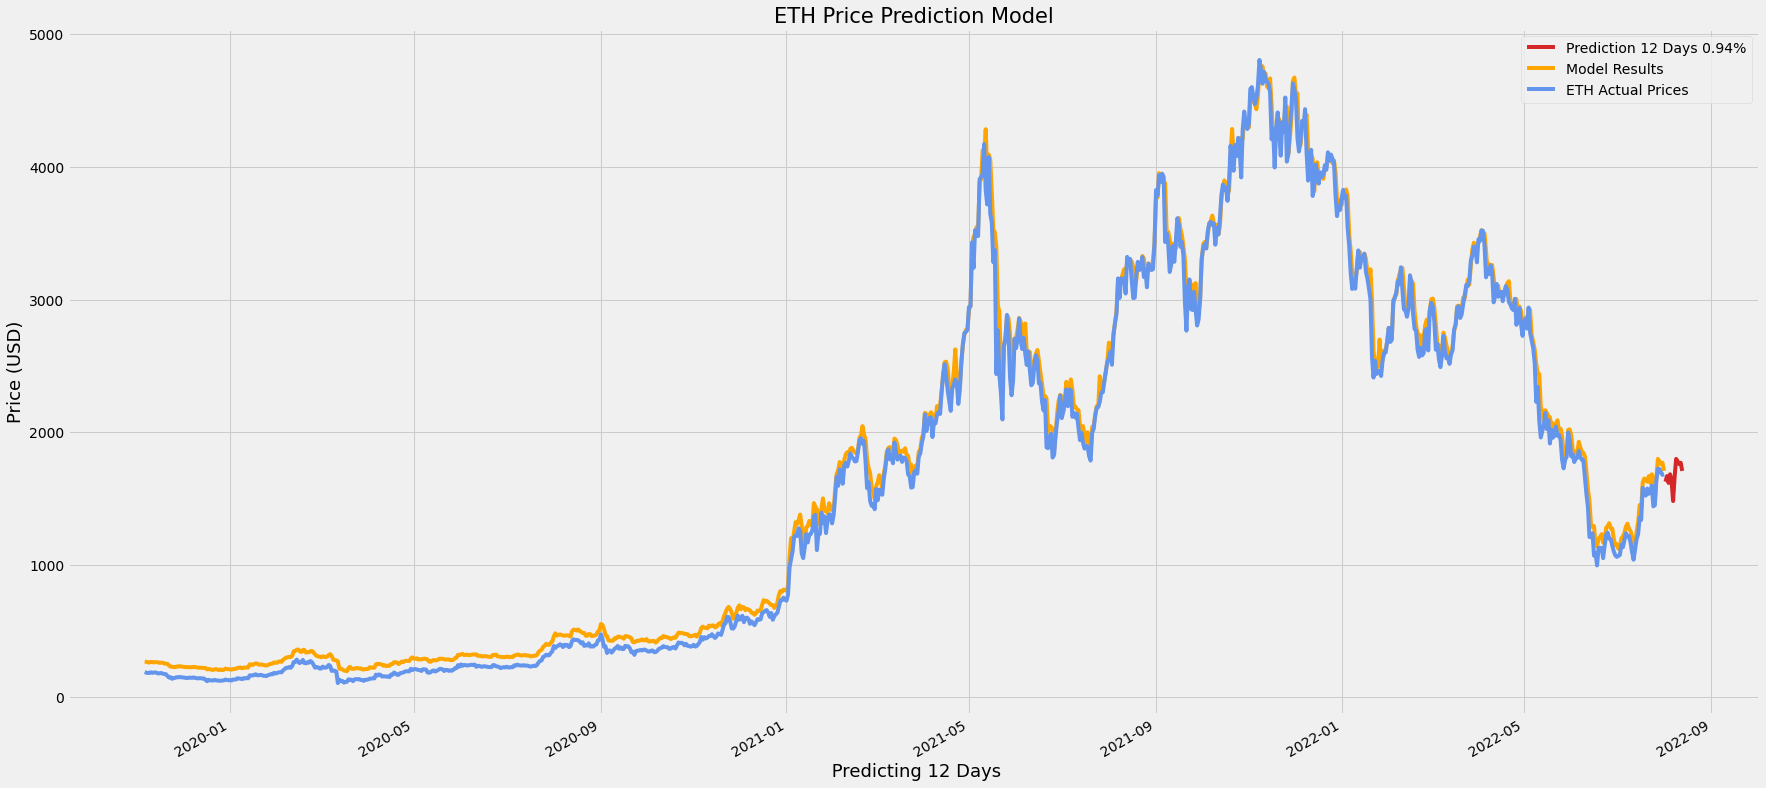

<module 'matplotlib.pylab' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pylab.py'>

In [538]:
import matplotlib.dates as mdates

def plot_model():
  plt.figure(figsize=(27,14))
  plt.plot(forecast_df.forecast, color='tab:red', label = f'Prediction {forecast_days} Days {accuracy_score}%')
  plt.plot(model_predictions_df, color='orange', label = 'Model Results')
  plt.plot(crypto_df.close, color='cornflowerblue', label = f'{symbol} Actual Prices')
  plt.title(f'{symbol} Price Prediction Model', fontsize=21)
  plt.xlabel(f' Predicting {forecast_days} Days', fontsize=18)
  plt.ylabel('Price (USD)', fontsize=18)
  plt.legend(loc='upper right')
  plt.gcf().autofmt_xdate()

  plt.show()

  return plt

plot_model()

In [539]:
forecast_df.style.background_gradient(axis=None, low=0.75, high=2)

,forecast
Date,
2022-08-02 00:00:00,1626.812689
2022-08-03 00:00:00,1669.157177
2022-08-04 00:00:00,1617.713476
2022-08-05 00:00:00,1682.887668
2022-08-06 00:00:00,1630.242909
2022-08-07 00:00:00,1480.888990
2022-08-08 00:00:00,1663.766830
2022-08-09 00:00:00,1798.621582
2022-08-10 00:00:00,1780.557675
